In [11]:
import os
import time
import copy
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torchvision as tv
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

from models import *
from utils import *
from datasets import *

# generate imgs

In [2]:
model = MMModel(
        MM_I_wPATH="./results/encoder_weights.pt", 
        MM_II_wPATH=None, 
        freeze=(True, True), 
        device=torch.device('cuda')
    )
model.eval()

MMModel(
  (MM_I): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=4608, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=2, bias=True)
  )
  (MM_II): HumanModel(
    (cnn): ResNet(
      (conv1): Sequential(
        (0): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2_x): Sequential(
        (0): BasicBlock(
          (residual_function): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [3]:
from torch.utils.data import DataLoader, TensorDataset

# data preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=False, transform=transform)
testset = tv.datasets.MNIST(root='./data',  train=False, download=False, transform=transform)

X_train = [i[0].unsqueeze(0) for i in trainset]
X_train = torch.vstack(X_train)
y_train = torch.tensor([i[1] for i in trainset])
print("X_train.shape: {}".format(X_train.shape))        # X_train.shape: torch.Size([60000, 1, 28, 28])

X_test = [i[0].unsqueeze(0) for i in testset]
X_test = torch.vstack(X_test)
y_test = torch.tensor([i[1] for i in testset])
print("X_test.shape: {}".format(X_test.shape))          # X_test.shape: torch.Size([10000, 1, 28, 28])

X_train.shape: torch.Size([60000, 1, 28, 28])
X_test.shape: torch.Size([10000, 1, 28, 28])


In [4]:
# train dataset
train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(X_train)), batch_size=10000, shuffle=False)

# testing
outputs = []
with torch.no_grad():
    for batch_x, batch_y in tqdm(train_loader):
        output = model.MM_I(batch_x.cuda()).detach().cpu().numpy()
        outputs.append(output)

outputs = np.concatenate(outputs, axis=0)
outputs.shape

100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


(60000, 2)

d:\anaconda3\envs\torch\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 9600x7200 with 0 Axes>

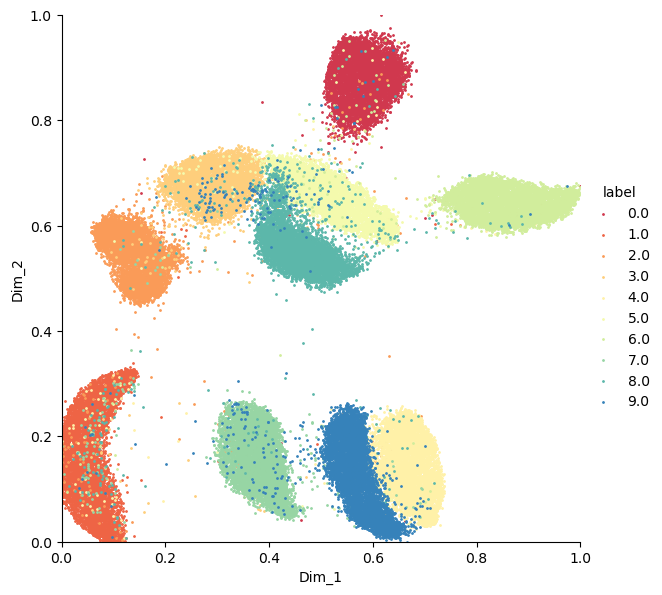

In [5]:
draw_z(normalise(outputs), cls=y_train, s=1)

In [18]:
draw_z(normalise(outputs), cls=y_test, s=1)

d:\anaconda3\envs\torch\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 9600x7200 with 0 Axes>

In [12]:
for i in range(6):
    draw_z(
        z=normalise(outputs[i*10000:(i+1)*10000]), 
        cls=y_train[i*10000:(i+1)*10000], 
        s=1, 
        save_path="./results/231016000038_I_1/train_{}.png".format(i), 
        display=False
    )

# give feedback

## Global

### 1. Do you think the DR result is aesthetically pleasing?
- Human: score from 1 to 5 (ugly/dislike/okay/good/pleasant)

In [13]:
q1 = [0, 1, 0, 0, 0]

### 2. How do you think intervals between the clusters in DR result?
<!-- - Human:
    - 5: all clusters are at reasonable distance from each other
    - 4: clusters are at reasonable distance in general
    - 3: 
    - 2: 
    - 1: all clusters are too far away from each other -->

- Human: scores from 1 to 5 (ugly/dislike/okay/good/pleasant)

In [14]:
q2 = [1, 0, 0, 0, 0]

### 3. Do you like the shape of these clusters?
- Human: score from 1 to 5

In [15]:
q3 = [0, 1, 0, 0, 0]

### 4. Do you like the relative positions between clusters?
- Human: score from 1 to 5

In [16]:
q4 = [1, 0, 0, 0, 0]

## Local

### 5. Heuristics ROIs

#### 5.1 Region with the highest entropy
- Do you think the DR result in this region is aesthetically pleasing?
    - Human: score from 1 to 5
- What do you think the misclassified datapoints in this region?
    - Human: It’s inspiring/It’s preferable/It’s okay/It’s not preferable/It’s intolerable



In [ ]:
# TODO

## collect answers above

In [19]:
q = [q1, q2, q3, q4]
q = torch.Tensor(q)
q, q.shape

(tensor([[0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.]]),
 torch.Size([4, 5]))

In [20]:
torch.save(q, "./results/231016000038_I_1/feedback.pt")

In [22]:
q = torch.load("./results/231016000038_I_1/feedback.pt")
q

tensor([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])